This tutorial continues part one, and recovers planets *c* and *d* in the K2-3 system. Planet *d* is a Super-Earth in the habitable zone. First, we recover planet *b* again:

In [1]:
import numpy
import scipy
import everest
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.CRITICAL)
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
EPIC_id = 201367065        
star = everest.Everest(EPIC_id)
t = numpy.delete(star.time, star.badmask)
y = numpy.delete(star.fcor, star.badmask)
t = numpy.array(t[~numpy.isnan(y)], dtype='float32')
y = numpy.array(y[~numpy.isnan(y)], dtype='float32')
trend = scipy.signal.medfilt(y, 25)
y_filt = y /trend
y_filt = sigma_clip(y_filt, sigma_upper=2, sigma_lower=float('inf'))
from transitleastsquares import transitleastsquares, catalog_info
ab, mass, mass_min, mass_max, radius, radius_min, radius_max = catalog_info(EPIC_id)
model = transitleastsquares(t, y_filt)
results = model.power(
    transit_depth_min=50*10**-6,
    period_min=9,
    period_max=11,
    R_star=radius,
    M_star=mass,
    R_star_min=radius - 3*radius_min,
    R_star_max=radius + 3*radius_max,
    M_star_min=mass - 3*mass_min,
    M_star_max=mass + 3*mass_max,
    u=ab)
plt.figure()
plt.plot(
    results.model_folded_phase,
    results.model_folded_model,
    color='red')
plt.scatter(
    results.folded_phase,
    results.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
plt.xlim(0.49, 0.51)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

/home/michael/.local/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201367065.
Transit Least Squares TLS 1.0.5 (03 January 2019)
duration_min 0.0005506607929515419
duration_max 0.06466976658819108
Creating model cache for 52 durations
Searching 3632 data points, 595 periods from 9.002 to 10.997 days, using all 8 CPU threads


100%|██████████| 595/595 periods | 00:02<00:00
  0%|          | 1/3632 [00:00<06:04,  9.97it/s]

Searching for best T0 for period 10.05458


100%|██████████| 3632/3632 [00:02<00:00, 1617.39it/s]


Now, we use the ``transit_mask`` function to mask the in-transit points of planet *b*. There are apparently more transits of another planet:

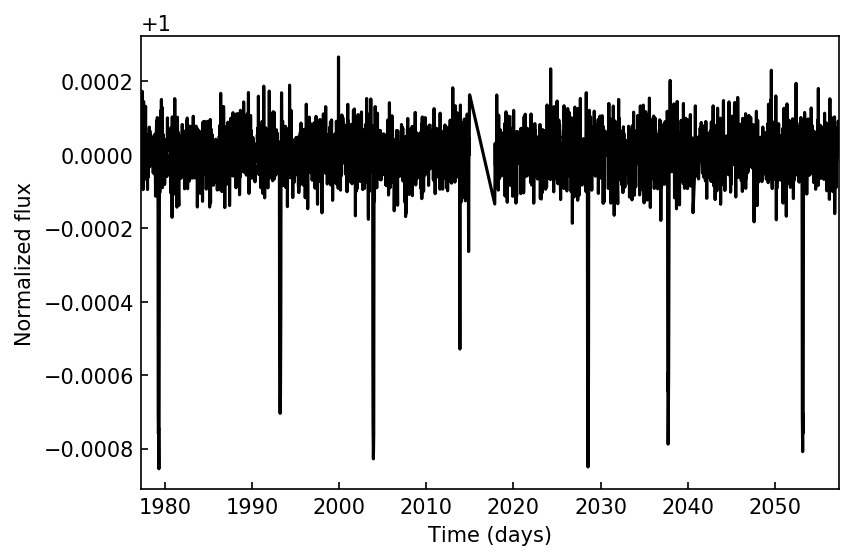

In [2]:
from transitleastsquares import transit_mask, cleaned_array
intransit = transit_mask(t, results.period, 2*results.duration, results.T0)
y_second_run = y_filt[~intransit]
t_second_run = t[~intransit]
t_second_run, y_second_run = cleaned_array(t_second_run, y_second_run)
from matplotlib import rcParams; rcParams["figure.dpi"] = 150
plt.figure()
ax = plt.gca()
ax.plot(t_second_run, y_second_run, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Normalized flux");

The second run and resulting power spectrum:

Transit Least Squares TLS 1.0.5 (03 January 2019)
duration_min 0.0005641748942172073
duration_max 0.12
Creating model cache for 58 durations
Searching 3545 data points, 26550 periods from 0.211 to 40.036 days, using all 8 CPU threads


100%|██████████| 26550/26550 periods | 00:16<00:00 
 14%|█▍        | 493/3545 [00:00<00:00, 4928.71it/s]

Searching for best T0 for period 24.65038


100%|██████████| 3545/3545 [00:00<00:00, 11238.13it/s]


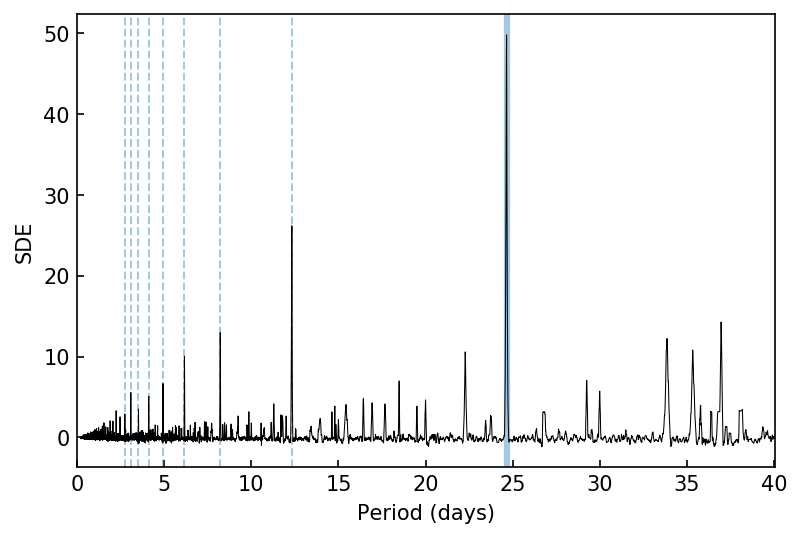

In [3]:
model_second_run = transitleastsquares(t_second_run, y_second_run)
results_second_run = model_second_run.power(
    R_star=radius,
    M_star=mass,
    R_star_min=radius - 3*radius_min,
    R_star_max=radius + 3*radius_max,
    M_star_min=mass - 3*mass_min,
    M_star_max=mass + 3*mass_max,
    u=ab)
plt.figure()
ax = plt.gca()
ax.axvline(results_second_run.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results_second_run.periods), numpy.max(results_second_run.periods))
for n in range(2, 10):
    ax.axvline(n*results_second_run.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results_second_run.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results_second_run.periods, results_second_run.power, color='black', lw=0.5)
plt.xlim(0, max(results_second_run.periods));

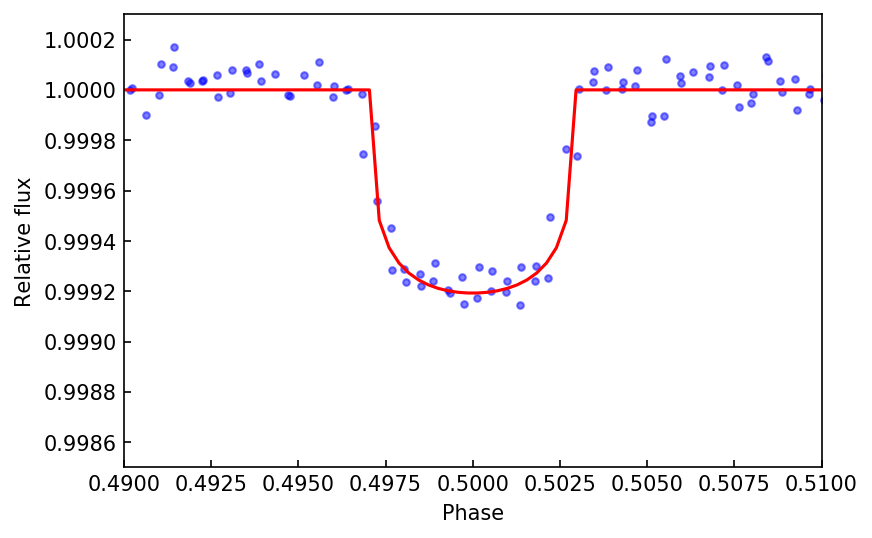

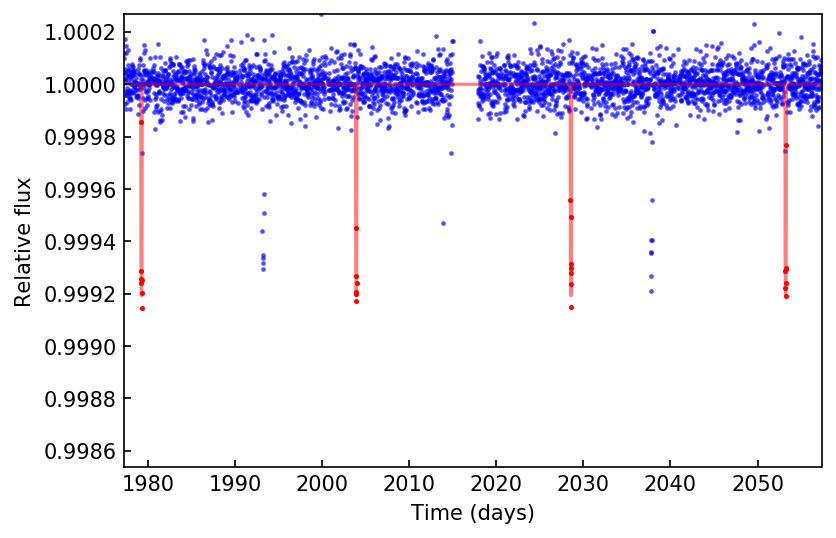

In [4]:
plt.figure()
plt.plot(
    results_second_run.model_folded_phase,
    results_second_run.model_folded_model,
    color='red')
plt.scatter(
    results_second_run.folded_phase,
    results_second_run.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
plt.xlim(0.49, 0.51)
plt.ylim(0.9985, 1.0003)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

plt.figure()
in_transit = transit_mask(
    t_second_run,
    results_second_run.period,
    results_second_run.duration,
    results_second_run.T0)
plt.scatter(
    t_second_run[in_transit],
    y_second_run[in_transit],
    color='red',
    s=2,
    zorder=0)
plt.scatter(
    t_second_run[~in_transit],
    y_second_run[~in_transit],
    color='blue',
    alpha=0.5,
    s=2,
    zorder=0)
plt.plot(
    results_second_run.model_lightcurve_time,
    results_second_run.model_lightcurve_model, alpha=0.5, color='red', zorder=1)
plt.xlim(min(t), max(t))
plt.ylim(min(y_filt), max(y_filt))
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');

Looks like another planet (*c*). Again, we mask *c* and inspect the time series:

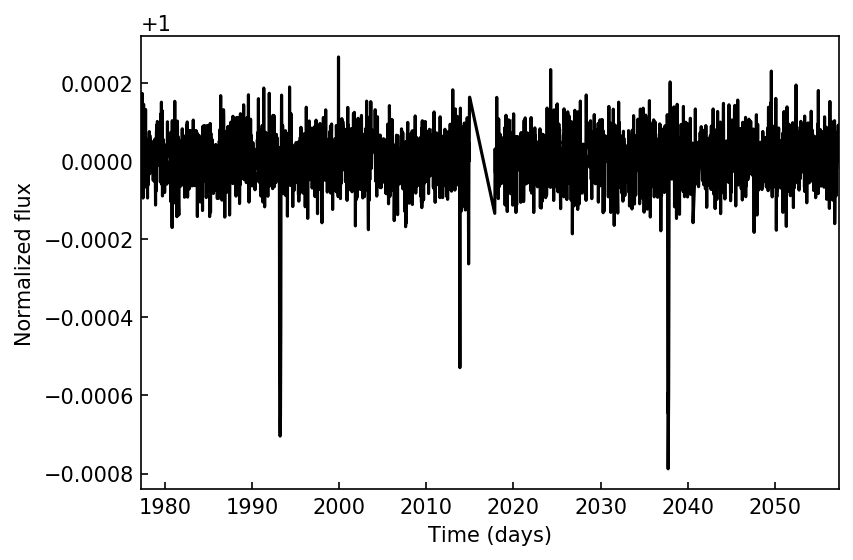

In [5]:

intransit = transit_mask(t_second_run, results_second_run.period, 2*results_second_run.duration, results_second_run.T0)

y_third_run = y_second_run[~intransit]
t_third_run = t_second_run[~intransit]
t_third_run, y_third_run = cleaned_array(t_third_run, y_third_run)


from matplotlib import rcParams; rcParams["figure.dpi"] = 150
plt.figure()
ax = plt.gca()
ax.plot(t_third_run, y_third_run, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Normalized flux");


Transit Least Squares TLS 1.0.5 (03 January 2019)
duration_min 0.0005729017473503294
duration_max 0.12
Creating model cache for 58 durations
Searching 3491 data points, 46173 periods from 0.211 to 80.072 days, using all 8 CPU threads


100%|██████████| 46173/46173 periods | 00:25<00:00  
 42%|████▏     | 1481/3491 [00:00<00:00, 14807.93it/s]

Searching for best T0 for period 44.54960


100%|██████████| 3491/3491 [00:00<00:00, 14877.47it/s]


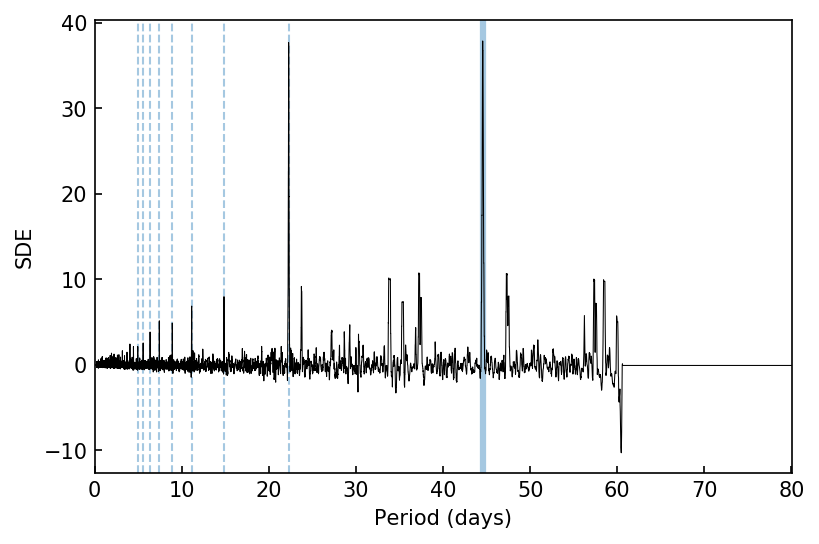

In [8]:
model_third_run = transitleastsquares(t_third_run, y_third_run)
results_third_run = model_third_run.power(
    R_star=radius,
    M_star=mass,
    R_star_min=radius - 3*radius_min,
    R_star_max=radius + 3*radius_max,
    M_star_min=mass - 3*mass_min,
    M_star_max=mass + 3*mass_max,
    n_transits_min=1,
    u=ab,
    oversampling_factor=5)
plt.figure()
ax = plt.gca()
ax.axvline(results_third_run.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results_third_run.periods), numpy.max(results_third_run.periods))
for n in range(2, 10):
    ax.axvline(n*results_third_run.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results_third_run.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results_third_run.periods, results_third_run.power, color='black', lw=0.5)
plt.xlim(0, max(results_third_run.periods));

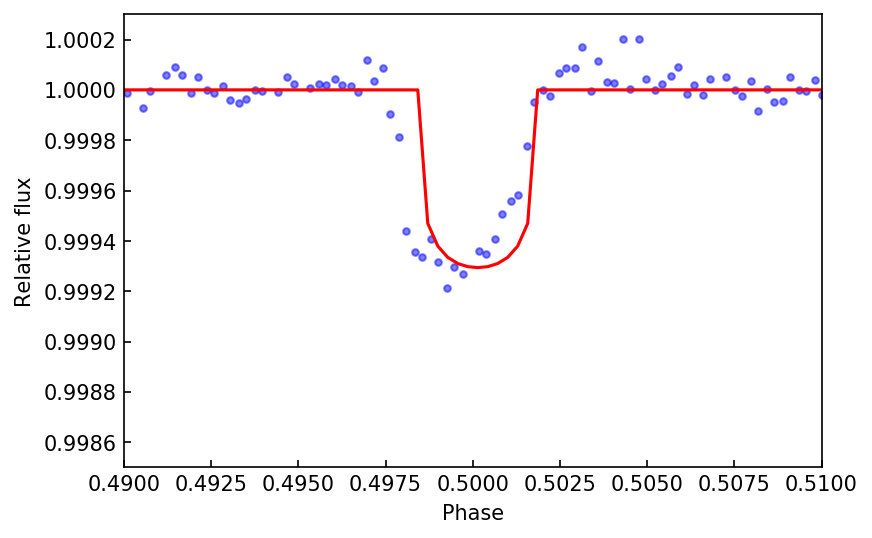

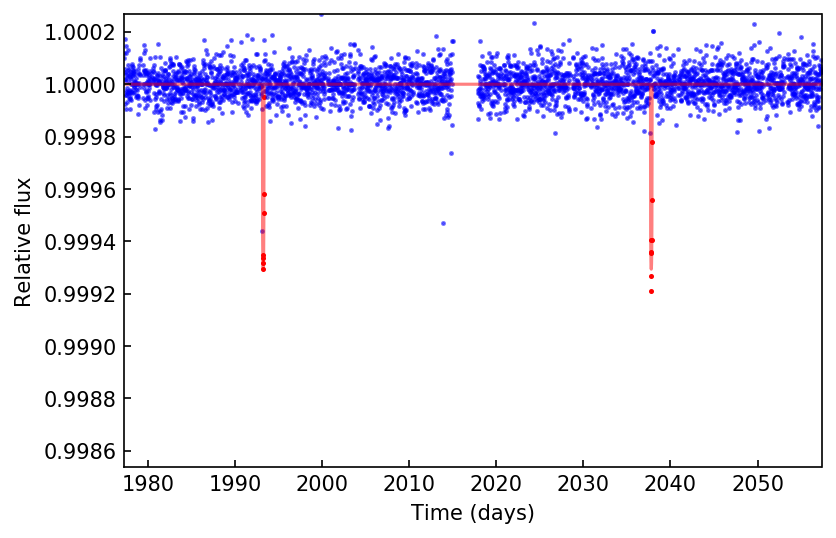

In [9]:
plt.figure()
plt.plot(
    results_third_run.model_folded_phase,
    results_third_run.model_folded_model,
    color='red')
plt.scatter(
    results_third_run.folded_phase,
    results_third_run.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
plt.xlim(0.49, 0.51)
plt.ylim(0.9985, 1.0003)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

plt.figure()
in_transit = transit_mask(
    t_third_run,
    results_third_run.period,
    results_third_run.duration,
    results_third_run.T0)
plt.scatter(
    t_third_run[in_transit],
    y_third_run[in_transit],
    color='red',
    s=2,
    zorder=0)
plt.scatter(
    t_third_run[~in_transit],
    y_third_run[~in_transit],
    color='blue',
    alpha=0.5,
    s=2,
    zorder=0)
plt.plot(
    results_third_run.model_lightcurve_time,
    results_third_run.model_lightcurve_model, alpha=0.5, color='red', zorder=1)
plt.xlim(min(t), max(t))
plt.ylim(min(y_filt), max(y_filt))
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');